In [1]:
# imports 
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
from pathlib import Path
import warnings
import glob
import os
import h5_utilities_module as h5u
warnings.filterwarnings("ignore", message="Mean of empty slice", category=RuntimeWarning)
import matplotlib.cm as cm


In [2]:
# where are the data?
data_dir = '/Users/thomaselston/Documents/PYTHON/self_control/decoder_output/'

# get their relevant paths
data_files = h5u.find_h5_files(data_dir)

In [3]:
#functions
def calculate_mean_and_interval(data, type='sem', num_samples=1000, alpha=0.05):
    """
    Calculate mean and either SEM or bootstrapped CI for each column of the input array, disregarding NaN values.

    Parameters:
    - data: 2D numpy array
    - type: str, either 'sem' or 'bootstrap_ci'
    - num_samples: int, number of bootstrap samples (applicable only for type='bootstrap_ci')
    - alpha: float, significance level for the confidence interval (applicable only for type='bootstrap_ci')

    Returns:
    - means: 1D numpy array containing means for each column
    - interval: 1D numpy array containing SEMs or bootstrapped CIs for each column
    """
    nan_mask = ~np.isnan(data)
    
    nanmean_result = np.nanmean(data, axis=0)
    n_valid_values = np.sum(nan_mask, axis=0)
    
    if type == 'sem':
        nanstd_result = np.nanstd(data, axis=0)
        interval = nanstd_result / np.sqrt(n_valid_values)
        
    elif type == 'percentile':
        interval = np.nanmean(np.array([np.abs(nanmean_result - np.nanpercentile (data, 5, axis=0)), np.abs(nanmean_result - np.nanpercentile (data, 95, axis=0))]))
        
    elif type == 'bootstrap':

        # Check if data is a 1D array (scalar vector)
        if data.ndim == 1:
            data = data.reshape(-1, 1)  # Reshape to (n, 1)
            nan_mask = nan_mask.reshape(-1, 1)  # Reshape to (n, 1)
            
        n_rows, n_cols = data.shape

        # Initialize array to store bootstrap means
        bootstrap_means = np.zeros((num_samples, n_cols))

        # Perform bootstrap resampling for each column
        for col in range(n_cols):
            
            if np.sum(nan_mask[:, col]) > 0:
                bootstrap_samples = np.random.choice(data[:, col][nan_mask[:, col]], size=(num_samples, n_rows), replace=True)
                bootstrap_means[:, col] = np.nanmean(bootstrap_samples, axis=1)
            else:
                bootstrap_means[:, col] = np.nan

        # Calculate confidence interval bounds
        ci_lower = np.percentile(bootstrap_means, 100 * (alpha / 2), axis=0)
        ci_upper = np.percentile(bootstrap_means, 100 * (1 - alpha / 2), axis=0)
        
        interval = np.nanmean([abs(bootstrap_means - ci_lower), abs(bootstrap_means - ci_upper)], axis=0)
        
        interval = np.nanmean(interval, axis=0)

    else:
        raise ValueError("Invalid 'type' argument. Use either 'sem' or 'bootstrap'.")
    
    # Ensure that the output is a scalar if there is only one value
    if nanmean_result.size == 1:
        nanmean_result = nanmean_result.item()  # Convert array to scalar
    if interval.size == 1:
        interval = interval.item()  # Convert array to scalar
    
    return nanmean_result, interval



def get_ch_and_unch_vals(bhv):
    """
    Extracts chosen (ch_val) and unchosen (unch_val) values associated with each trial.

    Parameters:
    - bhv (DataFrame): DataFrame behavioral data.

    Returns:
    - ch_val (ndarray): Array of chosen values for each trial.
    - unch_val (ndarray): Array of unchosen values for each trial. 
                          - places 0s for unchosen values on forced choice trials
    """
    ch_val = np.zeros(shape=(len(bhv, )))
    unch_val = np.zeros(shape=(len(bhv, )))

    bhv['r_val'] = bhv['r_val'].fillna(0)
    bhv['l_val'] = bhv['l_val'].fillna(0)

    ch_left = bhv['side'] == -1
    ch_right = bhv['side'] == 1

    ch_val[ch_left] = bhv['l_val'].loc[ch_left].astype(int)
    ch_val[ch_right] = bhv['r_val'].loc[ch_right].astype(int)

    unch_val[ch_left] = bhv['r_val'].loc[ch_left].astype(int)
    unch_val[ch_right] = bhv['l_val'].loc[ch_right].astype(int)

    return ch_val, unch_val

def normalize_data(data, axis=None):
    """
    Normalize the input data to the range [0, 1].

    Parameters:
    - data: numpy array, the data to be normalized.
    - axis: int, list of ints, or 'all', the axis or axes along which to normalize. 
            If 'all', the entire array is normalized.

    Returns:
    - normalized_data: numpy array, the normalized data.
    """
    data = np.asarray(data)  # Ensure data is a numpy array
    
    if axis == 'all':
        min_val = np.nanmin(data)
        max_val = np.nanmax(data)
        normalized_data = (data - min_val) / (max_val - min_val)
    
    elif axis is not None:
        min_val = np.nanmin(data, axis=axis, keepdims=True)
        max_val = np.nanmax(data, axis=axis, keepdims=True)
        normalized_data = (data - min_val) / (max_val - min_val)
    
    else:
        min_val = np.nanmin(data)
        max_val = np.nanmax(data)
        normalized_data = (data - min_val) / (max_val - min_val)
    
    return normalized_data

In [4]:
h5u.list_hdf5_data(data_files[0])

Datasets in '/Users/thomaselston/Documents/PYTHON/self_control/decoder_output/K20240715_Rec09_decoder.h5':
CdN_acc_mean
CdN_alt_ch
CdN_alt_unch
CdN_ch
CdN_pp
CdN_unch
OFC_acc_mean
OFC_alt_ch
OFC_alt_unch
OFC_ch
OFC_pp
OFC_unch
bhv
ts


In [5]:
# initialize lists to accumulate data into
OFC_ch = []
OFC_unch = []
OFC_alt_ch = []
OFC_alt_unch = []
CdN_ch = []
CdN_unch = []
CdN_alt_ch = []
CdN_alt_unch = []
bhv = pd.DataFrame()
OFC_acc = []
CdN_acc = []
subject = []
session = []
OFC_cue_pp = []


# accumulate data from each file

for f_num, this_file in enumerate(data_files):
    
    if 'D' in Path(this_file).stem:
        s = 0
    else:
        s = 1
            
    # Append the data to the lists
    subject.append(np.ones(len(h5u.pull_from_h5(this_file, 'OFC_acc_mean')), )*s)
    session.append(np.ones(len(h5u.pull_from_h5(this_file, 'OFC_acc_mean')), )*f_num)

    bhv = pd.concat([bhv, pd.read_hdf(this_file, key='bhv')], ignore_index=True)
    
    OFC_ch.append(h5u.pull_from_h5(this_file, 'OFC_ch'))
    OFC_unch.append(h5u.pull_from_h5(this_file, 'OFC_unch'))
    OFC_alt_ch.append(h5u.pull_from_h5(this_file, 'OFC_alt_ch'))
    OFC_alt_unch.append(h5u.pull_from_h5(this_file, 'OFC_alt_unch'))
    
    CdN_ch.append(h5u.pull_from_h5(this_file, 'CdN_ch'))
    CdN_unch.append(h5u.pull_from_h5(this_file, 'CdN_unch'))
    CdN_alt_ch.append(h5u.pull_from_h5(this_file, 'CdN_alt_ch'))
    CdN_alt_unch.append(h5u.pull_from_h5(this_file, 'CdN_alt_unch'))
    
    OFC_acc.append(h5u.pull_from_h5(this_file, 'OFC_acc_mean'))
    CdN_acc.append(h5u.pull_from_h5(this_file, 'CdN_acc_mean'))
    
    ts = h5u.pull_from_h5(this_file, 'ts')
    
    # pull the posteriors
    OFC_pp = h5u.pull_from_h5(this_file, 'OFC_pp')
    
    # get the mean during the rule epoch
    cue_start = np.argwhere(ts == -500)[0][0]
    cue_end = np.argwhere(ts == -100)[0][0]
    
    OFC_cue_pp.append(np.mean(OFC_pp[:, cue_start:cue_end,:], axis=1))
    
  


# convert everything back to arrays
subject = np.concatenate(subject, axis=0)
session = np.concatenate(session, axis=0)

OFC_ch = np.concatenate(OFC_ch, axis=0)
OFC_unch = np.concatenate(OFC_unch, axis=0)
OFC_alt_ch = np.concatenate(OFC_alt_ch, axis=0)
OFC_alt_unch = np.concatenate(OFC_alt_unch, axis=0)

CdN_ch = np.concatenate(CdN_ch, axis=0)
CdN_unch = np.concatenate(CdN_unch, axis=0)
CdN_alt_ch = np.concatenate(CdN_alt_ch, axis=0)
CdN_alt_unch = np.concatenate(CdN_alt_unch, axis=0)

OFC_acc = np.concatenate(OFC_acc, axis=0)
CdN_acc = np.concatenate(CdN_acc, axis=0)

OFC_cue_pp = np.concatenate(OFC_cue_pp, axis=0)


In [6]:
# get the labels associated with each unique state-value pair
ch_val, unch_val = get_ch_and_unch_vals(bhv)
s_ch_val = ch_val.copy()
s_unch_val = unch_val.copy()

s_ch_val[bhv['state'] == 2] = s_ch_val[bhv['state'] == 2] + 4
s_ch_val[bhv['state'] == 3] = s_ch_val[bhv['state'] == 3] + 8
s_unch_val[bhv['state'] == 2] = s_unch_val[bhv['state'] == 2] + 4
s_unch_val[bhv['state'] == 3] = s_unch_val[bhv['state'] == 3] + 8

In [7]:
session_ids = np.unique(session)

ofc_session_acc = np.zeros((len(session_ids), len(ts), 2))
cdn_session_acc = np.zeros((len(session_ids), len(ts), 2))

sess_subject = np.zeros(len(session_ids), )


for sess_ix, sess_id in enumerate(session_ids):
    
    trials2use = session == sess_ix

    if subject[trials2use][0] == 0:
        sess_subject[sess_ix] = 0
    else:
        sess_subject[sess_ix] = 1
    
    ofc_session_acc[sess_ix, :, 0] = np.mean(OFC_acc[trials2use & (bhv['n_sacc'] == 1)], axis=0)
    ofc_session_acc[sess_ix, :, 1] = np.mean(OFC_acc[trials2use & (bhv['n_sacc'] == 2)], axis=0)
    
    cdn_session_acc[sess_ix, :, 0] = np.mean(CdN_acc[trials2use & (bhv['n_sacc'] == 1)], axis=0)
    cdn_session_acc[sess_ix, :, 1] = np.mean(CdN_acc[trials2use & (bhv['n_sacc'] == 2)], axis=0)


(0.0, 1.0)

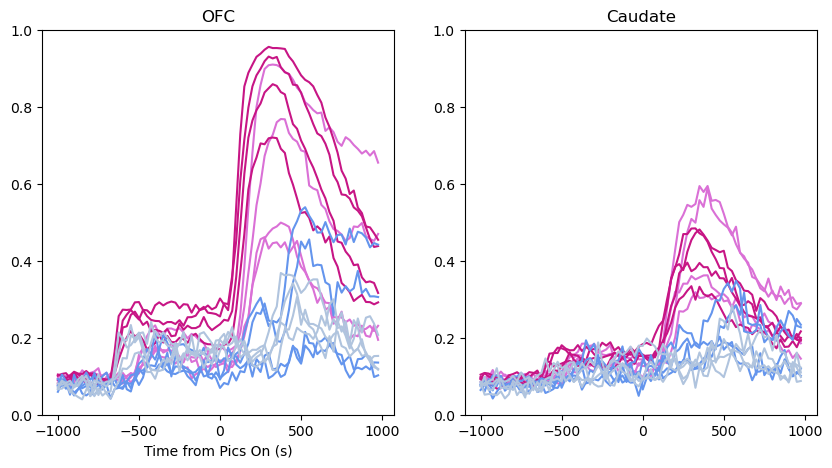

In [8]:
fig, ax = plt.subplots(1, 2, figsize=(10, 5))

d_ofc = ofc_session_acc[sess_subject == 0,:,:]
d_cdn = cdn_session_acc[sess_subject == 0,:,:]

k_ofc = ofc_session_acc[sess_subject == 1,:,:]
k_cdn = cdn_session_acc[sess_subject == 1,:,:]


ax[0].plot(ts, d_ofc[:,:,0].T, color='orchid')
ax[0].plot(ts, k_ofc[:,:,0].T, color='mediumvioletred')
ax[0].plot(ts, d_ofc[:,:,1].T, color='cornflowerblue')
ax[0].plot(ts, k_ofc[:,:,1].T, color='lightsteelblue')
ax[0].set_title('OFC')
ax[0].set_xlabel('Time from Pics On (s)')
ax[0].set_ylim((0,1))

ax[1].plot(ts, d_cdn[:,:,0].T, color='orchid')
ax[1].plot(ts, k_cdn[:,:,0].T, color='mediumvioletred')
ax[1].plot(ts, d_cdn[:,:,1].T, color='cornflowerblue')
ax[1].plot(ts, k_cdn[:,:,1].T, color='lightsteelblue')
ax[1].set_title('Caudate')
ax[1].set_ylim((0,1))

#plt.savefig("Single_session_decoding.svg")


In [9]:
k_OFC_s12_single_sacc_mean, k_OFC_s12_single_sacc_CI = calculate_mean_and_interval(OFC_acc[(subject == 1) & (bhv['n_sacc'] == 1), :]*100, 'bootstrap')
    
k_OFC_s12_double_sacc_mean, k_OFC_s12_double_sacc_CI = calculate_mean_and_interval(OFC_acc[(subject == 1) & (bhv['n_sacc'] == 2), :]*100, 'bootstrap')

d_OFC_s12_single_sacc_mean, d_OFC_s12_single_sacc_CI = calculate_mean_and_interval(OFC_acc[(subject == 0) & (bhv['n_sacc'] == 1), :]*100, 'bootstrap')
    
d_OFC_s12_double_sacc_mean, d_OFC_s12_double_sacc_CI = calculate_mean_and_interval(OFC_acc[(subject == 0) & (bhv['n_sacc'] == 2), :]*100, 'bootstrap')

k_CdN_s12_single_sacc_mean, k_CdN_s12_single_sacc_CI = calculate_mean_and_interval(CdN_acc[(subject == 1) & (bhv['n_sacc'] == 1), :]*100, 'bootstrap')
    
k_CdN_s12_double_sacc_mean, k_CdN_s12_double_sacc_CI = calculate_mean_and_interval(CdN_acc[(subject == 1) & (bhv['n_sacc'] == 2), :]*100, 'bootstrap')

d_CdN_s12_single_sacc_mean, d_CdN_s12_single_sacc_CI = calculate_mean_and_interval(CdN_acc[(subject == 0) & (bhv['n_sacc'] == 1), :]*100, 'bootstrap')
    
d_CdN_s12_double_sacc_mean, d_CdN_s12_double_sacc_CI = calculate_mean_and_interval(CdN_acc[(subject == 0) & (bhv['n_sacc'] == 2), :]*100, 'bootstrap')

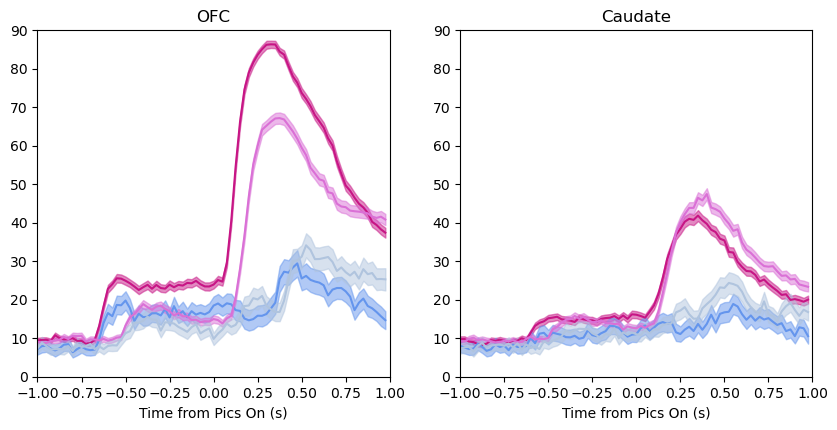

In [75]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))

ts2 = ts/1000

ax[0].fill_between(ts2, k_OFC_s12_single_sacc_mean - k_OFC_s12_single_sacc_CI, 
                       k_OFC_s12_single_sacc_mean + k_OFC_s12_single_sacc_CI, color='mediumvioletred', alpha=.5)
ax[0].plot(ts2, k_OFC_s12_single_sacc_mean, color='mediumvioletred')
ax[0].fill_between(ts2, k_OFC_s12_double_sacc_mean - k_OFC_s12_double_sacc_CI, 
                       k_OFC_s12_double_sacc_mean + k_OFC_s12_double_sacc_CI, color='cornflowerblue', alpha=.5)
ax[0].plot(ts2, k_OFC_s12_double_sacc_mean, color='cornflowerblue')

ax[0].fill_between(ts2, d_OFC_s12_single_sacc_mean - d_OFC_s12_single_sacc_CI, 
                       d_OFC_s12_single_sacc_mean + d_OFC_s12_single_sacc_CI, color='orchid', alpha=.5)
ax[0].plot(ts2, d_OFC_s12_single_sacc_mean, color='orchid')
ax[0].fill_between(ts2, d_OFC_s12_double_sacc_mean - d_OFC_s12_double_sacc_CI, 
                       d_OFC_s12_double_sacc_mean + d_OFC_s12_double_sacc_CI, color='lightsteelblue', alpha=.5)
ax[0].plot(ts2, d_OFC_s12_double_sacc_mean, color='lightsteelblue')
ax[0].set_title('OFC')
ax[0].set_xlabel('Time from Pics On (s)')
ax[0].set_ylim((0,90))
ax[0].set_xlim((-1,1))


ax[1].fill_between(ts2, k_CdN_s12_single_sacc_mean - k_CdN_s12_single_sacc_CI, 
                       k_CdN_s12_single_sacc_mean + k_CdN_s12_single_sacc_CI, color='mediumvioletred', alpha=.5)
ax[1].plot(ts2, k_CdN_s12_single_sacc_mean, color='mediumvioletred')
ax[1].fill_between(ts2, k_CdN_s12_double_sacc_mean - k_CdN_s12_double_sacc_CI, 
                       k_CdN_s12_double_sacc_mean + k_CdN_s12_double_sacc_CI, color='cornflowerblue', alpha=.5)
ax[1].plot(ts2, k_CdN_s12_double_sacc_mean, color='cornflowerblue')

ax[1].fill_between(ts2, d_CdN_s12_single_sacc_mean - d_CdN_s12_single_sacc_CI, 
                       d_CdN_s12_single_sacc_mean + d_CdN_s12_single_sacc_CI, color='orchid', alpha=.5)
ax[1].plot(ts2, d_CdN_s12_single_sacc_mean, color='orchid')

ax[1].fill_between(ts2, d_CdN_s12_double_sacc_mean - d_CdN_s12_double_sacc_CI, 
                       d_CdN_s12_double_sacc_mean + d_CdN_s12_double_sacc_CI, color='lightsteelblue', alpha=.5)
ax[1].plot(ts2, d_CdN_s12_double_sacc_mean, color='lightsteelblue')
ax[1].set_title('Caudate')
ax[1].set_xlabel('Time from Pics On (s)')
ax[1].set_ylim((0,90))
ax[1].set_xlim((-1,1))


#plt.savefig("Decoding_Summary.svg")

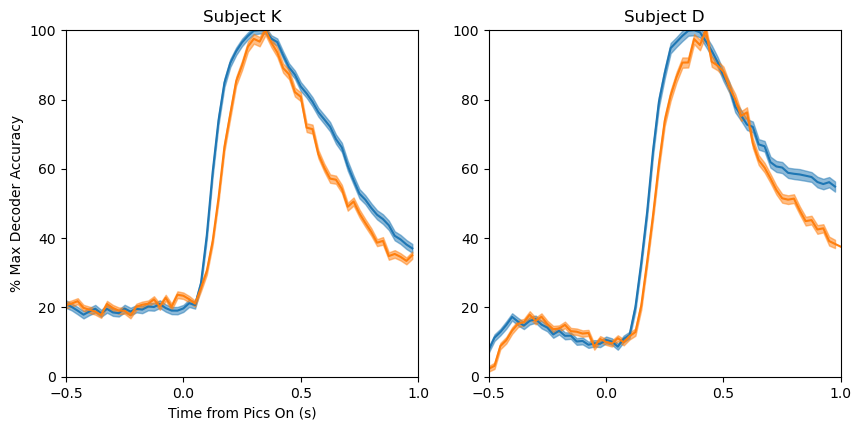

In [73]:
# examine latency

nrml_k_ofc_mean = normalize_data(k_OFC_s12_single_sacc_mean, axis=0)
nrml_d_ofc_mean = normalize_data(d_OFC_s12_single_sacc_mean, axis=0)

nrml_k_cdn_mean = normalize_data(k_CdN_s12_single_sacc_mean, axis=0)
nrml_d_cdn_mean = normalize_data(d_CdN_s12_single_sacc_mean, axis=0)

nrml_k_ofc_mean = nrml_k_ofc_mean*100
nrml_d_ofc_mean = nrml_d_ofc_mean*100
nrml_k_cdn_mean = nrml_k_cdn_mean*100
nrml_d_cdn_mean = nrml_d_cdn_mean*100

fig, ax = plt.subplots(1, 2, figsize=(10, 4.5))

ax[0].fill_between(ts2, nrml_k_ofc_mean - k_OFC_s12_single_sacc_CI, 
                   nrml_k_ofc_mean + k_OFC_s12_single_sacc_CI, color='tab:blue', alpha=.5)
ax[0].plot(ts2, nrml_k_ofc_mean, color='tab:blue')
ax[0].fill_between(ts2, nrml_k_cdn_mean - k_CdN_s12_single_sacc_CI, 
                   nrml_k_cdn_mean + k_CdN_s12_single_sacc_CI, color='tab:orange', alpha=.5)
ax[0].plot(ts2, nrml_k_cdn_mean, color='tab:orange')
ax[0].set_ylim((0,100))
ax[0].set_xlim((-.5, 1))
ax[0].set_xticks((-.5, 0, .5, 1))
ax[0].set_xlabel('Time from Pics On (s)')
ax[0].set_ylabel('% Max Decoder Accuracy')
ax[0].set_title('Subject K')



ax[1].fill_between(ts2, nrml_d_ofc_mean - d_OFC_s12_single_sacc_CI, 
                   nrml_d_ofc_mean + d_OFC_s12_single_sacc_CI, color='tab:blue', alpha=.5)
ax[1].plot(ts2, nrml_d_ofc_mean, color='tab:blue')

ax[1].fill_between(ts2, nrml_d_cdn_mean - d_CdN_s12_single_sacc_CI, 
                   nrml_d_cdn_mean + d_CdN_s12_single_sacc_CI, color='tab:orange', alpha=.5)
ax[1].plot(ts2, nrml_d_cdn_mean, color='tab:orange')
ax[1].set_ylim((0,100))
ax[1].set_xlim((-.5, 1))
ax[1].set_xticks((-.5, 0, .5, 1))
ax[1].set_title('Subject D')

#plt.savefig("Decoder_Latency.svg")

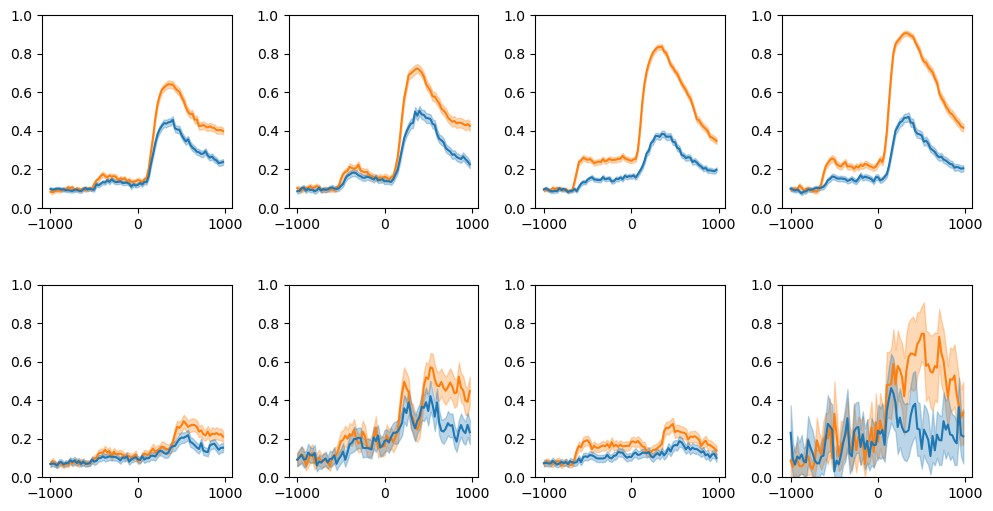

In [8]:
# make an integrated analysis and plotting function

# first instantiate the figure
fig, ax = plt.subplots(2, 4, figsize=(12, 6))
plt.subplots_adjust(wspace=0.3, hspace=0.4)  # add some white space

ofc_color = 'tab:orange'
cdn_color = 'tab:blue'

# now loop over the subjects
for s in np.unique(subject).astype(int):


    # get OFC means and CIs
    OFC_s12_single_sacc_mean, OFC_s12_single_sacc_CI = calculate_mean_and_interval(OFC_acc[(bhv['state'] < 3) &
                                                        (subject == s) & (bhv['n_sacc'] == 1), :], 'bootstrap')
    
    OFC_s12_double_sacc_mean, OFC_s12_double_sacc_CI = calculate_mean_and_interval(OFC_acc[(bhv['state'] < 3) & 
                                                                                        (subject == s) & (bhv['n_sacc'] == 2), :], 'bootstrap')

    OFC_s3_single_sacc_mean, OFC_s3_single_sacc_CI = calculate_mean_and_interval(OFC_acc[(bhv['state'] == 3) & 
                                                                                         (subject == s) & (bhv['n_sacc'] == 1), :], 'bootstrap')
    OFC_s3_double_sacc_mean, OFC_s3_double_sacc_CI = calculate_mean_and_interval(OFC_acc[(bhv['state'] == 3) & 
                                                                                         (subject == s) & (bhv['n_sacc'] == 2), :], 'bootstrap')
    
    # get CdN means and CIs
    CdN_s12_single_sacc_mean, CdN_s12_single_sacc_CI = calculate_mean_and_interval(CdN_acc[(bhv['state'] < 3) &
                                                        (subject == s) & (bhv['n_sacc'] == 1), :], 'bootstrap')
    
    CdN_s12_double_sacc_mean, CdN_s12_double_sacc_CI = calculate_mean_and_interval(CdN_acc[(bhv['state'] < 3) & 
                                                                                        (subject == s) & (bhv['n_sacc'] == 2), :], 'bootstrap')

    CdN_s3_single_sacc_mean, CdN_s3_single_sacc_CI = calculate_mean_and_interval(CdN_acc[(bhv['state'] == 3) & 
                                                                                         (subject == s) & (bhv['n_sacc'] == 1), :], 'bootstrap')
    CdN_s3_double_sacc_mean, CdN_s3_double_sacc_CI = calculate_mean_and_interval(CdN_acc[(bhv['state'] == 3) & 
                                                                                         (subject == s) & (bhv['n_sacc'] == 2), :], 'bootstrap')
    
    # now plot:
    ax[0,s*2].fill_between(ts,OFC_s12_single_sacc_mean-OFC_s12_single_sacc_CI, 
                            OFC_s12_single_sacc_mean+OFC_s12_single_sacc_CI, color=ofc_color, alpha=.3)
    ax[0,s*2].plot(ts,OFC_s12_single_sacc_mean, color=ofc_color)
    
    ax[0,s*2].fill_between(ts,CdN_s12_single_sacc_mean-CdN_s12_single_sacc_CI, 
                            CdN_s12_single_sacc_mean+CdN_s12_single_sacc_CI, color=cdn_color, alpha=.3)
    ax[0,s*2].plot(ts,CdN_s12_single_sacc_mean, color=cdn_color)
    ax[0,s*2].set_ylim((0, 1))

    ax[0,s*2+1].fill_between(ts,OFC_s3_single_sacc_mean-OFC_s3_single_sacc_CI, 
                            OFC_s3_single_sacc_mean+OFC_s3_single_sacc_CI, color=ofc_color, alpha=.3)
    ax[0,s*2+1].plot(ts,OFC_s3_single_sacc_mean, color=ofc_color)

    ax[0,s*2+1].fill_between(ts,CdN_s3_single_sacc_mean-CdN_s3_single_sacc_CI, 
                            CdN_s3_single_sacc_mean+CdN_s3_single_sacc_CI, color=cdn_color, alpha=.3)
    ax[0,s*2+1].plot(ts,CdN_s3_single_sacc_mean, color=cdn_color)
    ax[0,s*2+1].set_ylim((0, 1))
    

    ax[1,s*2].fill_between(ts, OFC_s12_double_sacc_mean-OFC_s12_double_sacc_CI, 
                            OFC_s12_double_sacc_mean+OFC_s12_double_sacc_CI, color=ofc_color, alpha=.3)
    ax[1,s*2].plot(ts,OFC_s12_double_sacc_mean, color=ofc_color)
    
    ax[1,s*2].fill_between(ts,CdN_s12_double_sacc_mean-CdN_s12_double_sacc_CI, 
                            CdN_s12_double_sacc_mean+CdN_s12_double_sacc_CI, color=cdn_color, alpha=.3)
    ax[1,s*2].plot(ts,CdN_s12_double_sacc_mean, color=cdn_color)
    ax[1,s*2].set_ylim((0, 1))


    ax[1,s*2+1].fill_between(ts, OFC_s3_double_sacc_mean-OFC_s3_double_sacc_CI, 
                            OFC_s3_double_sacc_mean+OFC_s3_double_sacc_CI, color=ofc_color, alpha=.3)
    ax[1,s*2+1].plot(ts,OFC_s3_double_sacc_mean, color=ofc_color)
    
    ax[1,s*2+1].fill_between(ts,CdN_s3_double_sacc_mean-CdN_s3_double_sacc_CI, 
                            CdN_s3_double_sacc_mean+CdN_s3_double_sacc_CI, color=cdn_color, alpha=.3)
    ax[1,s*2+1].plot(ts,CdN_s3_double_sacc_mean, color=cdn_color)
    ax[1,s*2+1].set_ylim((0, 1))

In [10]:
# subject D!
s_ix = subject < 3
sacc1_ix = (bhv['n_sacc'] == 1) & s_ix & (bhv['picked_best'] == 1)
sacc2_ix = (bhv['n_sacc'] == 2) & s_ix & (bhv['picked_best'] == 1)


# now let's look at the posteriors
OFC_s12_single_ch_mean, OFC_s12_single_ch_CI = calculate_mean_and_interval(OFC_ch[(bhv['state'] < 3) & sacc1_ix, :]-.03, 'bootstrap')
OFC_s12_double_ch_mean, OFC_s12_double_ch_CI = calculate_mean_and_interval(OFC_ch[(bhv['state'] < 3) & sacc2_ix, :], 'bootstrap')

OFC_s12_single_unch_mean, OFC_s12_single_unch_CI = calculate_mean_and_interval(OFC_unch[(bhv['state'] < 3) & sacc1_ix, :], 'bootstrap')
OFC_s12_double_unch_mean, OFC_s12_double_unch_CI = calculate_mean_and_interval(OFC_unch[(bhv['state'] < 3) & sacc2_ix, :], 'bootstrap')

OFC_s12_single_alt_ch_mean, OFC_s12_single_alt_ch_CI = calculate_mean_and_interval(OFC_alt_ch[(bhv['state'] < 3) & sacc1_ix, :], 'bootstrap')
OFC_s12_double_alt_ch_mean, OFC_s12_double_alt_ch_CI = calculate_mean_and_interval(OFC_alt_ch[(bhv['state'] < 3) & sacc2_ix, :], 'bootstrap')

OFC_s12_single_alt_unch_mean, OFC_s12_single_alt_unch_CI = calculate_mean_and_interval(OFC_alt_unch[(bhv['state'] < 3) & sacc1_ix, :], 'bootstrap')
OFC_s12_double_alt_unch_mean, OFC_s12_double_alt_unch_CI = calculate_mean_and_interval(OFC_alt_unch[(bhv['state'] < 3) & sacc2_ix, :], 'bootstrap')

OFC_s3_single_ch_mean, OFC_s3_single_ch_CI = calculate_mean_and_interval(OFC_ch[(bhv['state'] == 3) & sacc1_ix, :]-.03, 'bootstrap')
OFC_s3_double_ch_mean, OFC_s3_double_ch_CI = calculate_mean_and_interval(OFC_ch[(bhv['state'] == 3) & sacc2_ix, :], 'bootstrap')

OFC_s3_single_unch_mean, OFC_s3_single_unch_CI = calculate_mean_and_interval(OFC_unch[(bhv['state'] == 3) & sacc1_ix, :], 'bootstrap')
OFC_s3_double_unch_mean, OFC_s3_double_unch_CI = calculate_mean_and_interval(OFC_unch[(bhv['state'] == 3) & sacc2_ix, :], 'bootstrap')

OFC_s3_single_alt_ch_mean, OFC_s3_single_alt_ch_CI = calculate_mean_and_interval(OFC_alt_ch[(bhv['state'] == 3) & sacc1_ix, :], 'bootstrap')
OFC_s3_double_alt_ch_mean, OFC_s3_double_alt_ch_CI = calculate_mean_and_interval(OFC_alt_ch[(bhv['state'] == 3) & sacc2_ix, :], 'bootstrap')

OFC_s3_single_alt_unch_mean, OFC_s3_single_alt_unch_CI = calculate_mean_and_interval(OFC_alt_unch[(bhv['state'] == 3) & sacc1_ix, :], 'bootstrap')
OFC_s3_double_alt_unch_mean, OFC_s3_double_alt_unch_CI = calculate_mean_and_interval(OFC_alt_unch[(bhv['state'] == 3) & sacc2_ix, :], 'bootstrap')

CdN_s12_single_ch_mean, CdN_s12_single_ch_CI = calculate_mean_and_interval(CdN_ch[(bhv['state'] < 3) & sacc1_ix, :]-.03, 'bootstrap')
CdN_s12_double_ch_mean, CdN_s12_double_ch_CI = calculate_mean_and_interval(CdN_ch[(bhv['state'] < 3) & sacc2_ix, :], 'bootstrap')

CdN_s12_single_unch_mean, CdN_s12_single_unch_CI = calculate_mean_and_interval(CdN_unch[(bhv['state'] < 3) & sacc1_ix, :], 'bootstrap')
CdN_s12_double_unch_mean, CdN_s12_double_unch_CI = calculate_mean_and_interval(CdN_unch[(bhv['state'] < 3) & sacc2_ix, :], 'bootstrap')

CdN_s12_single_alt_ch_mean, CdN_s12_single_alt_ch_CI = calculate_mean_and_interval(CdN_alt_ch[(bhv['state'] < 3) & sacc1_ix, :], 'bootstrap')
CdN_s12_double_alt_ch_mean, CdN_s12_double_alt_ch_CI = calculate_mean_and_interval(CdN_alt_ch[(bhv['state'] < 3) & sacc2_ix, :], 'bootstrap')

CdN_s12_single_alt_unch_mean, CdN_s12_single_alt_unch_CI = calculate_mean_and_interval(CdN_alt_unch[(bhv['state'] < 3) & sacc1_ix, :]-.03, 'bootstrap')
CdN_s12_double_alt_unch_mean, CdN_s12_double_alt_unch_CI = calculate_mean_and_interval(CdN_alt_unch[(bhv['state'] < 3) & sacc2_ix, :]-.03, 'bootstrap')

CdN_s3_single_ch_mean, CdN_s3_single_ch_CI = calculate_mean_and_interval(CdN_ch[(bhv['state'] == 3) & sacc1_ix, :]-.03, 'bootstrap')
CdN_s3_double_ch_mean, CdN_s3_double_ch_CI = calculate_mean_and_interval(CdN_ch[(bhv['state'] == 3) & sacc2_ix, :], 'bootstrap')

CdN_s3_single_unch_mean, CdN_s3_single_unch_CI = calculate_mean_and_interval(CdN_unch[(bhv['state'] == 3) & sacc1_ix, :], 'bootstrap')
CdN_s3_double_unch_mean, CdN_s3_double_unch_CI = calculate_mean_and_interval(CdN_unch[(bhv['state'] == 3) & sacc2_ix, :], 'bootstrap')

CdN_s3_single_alt_ch_mean, CdN_s3_single_alt_ch_CI = calculate_mean_and_interval(CdN_alt_ch[(bhv['state'] == 3) & sacc1_ix, :], 'bootstrap')
CdN_s3_double_alt_ch_mean, CdN_s3_double_alt_ch_CI = calculate_mean_and_interval(CdN_alt_ch[(bhv['state'] == 3) & sacc2_ix, :], 'bootstrap')

CdN_s3_single_alt_unch_mean, CdN_s3_single_alt_unch_CI = calculate_mean_and_interval(CdN_alt_unch[(bhv['state'] == 3) & sacc1_ix, :], 'bootstrap')
CdN_s3_double_alt_unch_mean, CdN_s3_double_alt_unch_CI = calculate_mean_and_interval(CdN_alt_unch[(bhv['state'] == 3) & sacc2_ix, :], 'bootstrap')

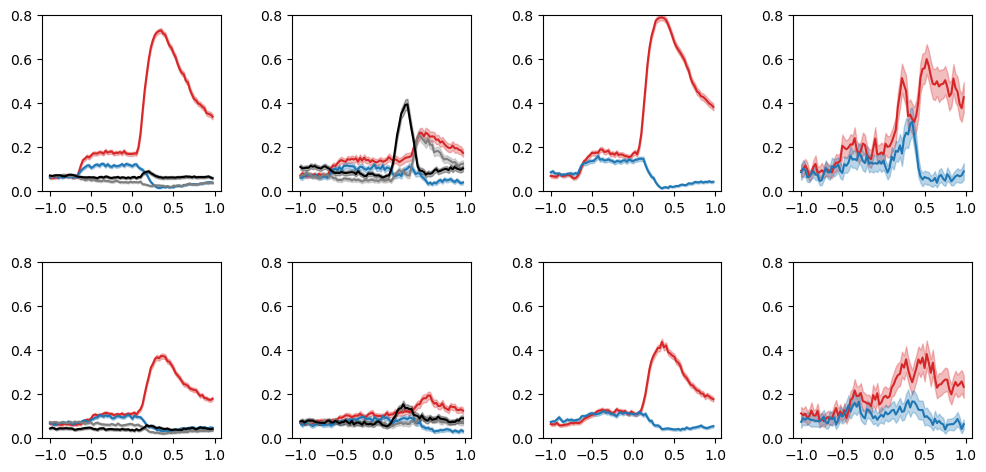

In [12]:
fig, ax = plt.subplots(2, 4, figsize=(12, 5.5))
plt.subplots_adjust(wspace=0.4, hspace=0.4)  # add some white space

ts2 = ts/1000
xticks = (-1, -.5, 0, .5, 1)

ch_col = 'tab:red'
unch_col = 'tab:blue'
alt_ch_col = 'tab:gray'
alt_unch_col = 'black'
alpha = .3
ofc_ylim = (0, .8)
cdn_ylim = (0, .8)


ax[0,0].plot(ts2, OFC_s12_single_ch_mean, color=ch_col)
ax[0,0].fill_between(ts2, OFC_s12_single_ch_mean-OFC_s12_single_ch_CI, OFC_s12_single_ch_mean+OFC_s12_single_ch_CI, color=ch_col, alpha=alpha)

ax[0,0].plot(ts2, OFC_s12_single_unch_mean, color=unch_col)
ax[0,0].fill_between(ts2, OFC_s12_single_unch_mean-OFC_s12_single_unch_CI, OFC_s12_single_unch_mean+OFC_s12_single_unch_CI, color=unch_col, alpha=alpha)

ax[0,0].plot(ts2, OFC_s12_single_alt_ch_mean, color=alt_ch_col)
ax[0,0].fill_between(ts2, OFC_s12_single_alt_ch_mean-OFC_s12_single_alt_ch_CI, OFC_s12_single_alt_ch_mean+OFC_s12_single_alt_ch_CI, color=alt_ch_col, alpha=alpha)

ax[0,0].plot(ts2, OFC_s12_single_alt_unch_mean, color=alt_unch_col)
ax[0,0].fill_between(ts2, OFC_s12_single_alt_unch_mean-OFC_s12_single_alt_unch_CI,
                         OFC_s12_single_alt_unch_mean+OFC_s12_single_alt_unch_CI, color=alt_unch_col, alpha=alpha)
ax[0,0].set_xticks(xticks)
ax[0,0].set_ylim(ofc_ylim)

ax[0,1].plot(ts2, OFC_s12_double_ch_mean, color=ch_col)
ax[0,1].fill_between(ts2, OFC_s12_double_ch_mean-OFC_s12_double_ch_CI, OFC_s12_double_ch_mean+OFC_s12_double_ch_CI, color=ch_col, alpha=alpha)

ax[0,1].plot(ts2, OFC_s12_double_unch_mean, color=unch_col)
ax[0,1].fill_between(ts2, OFC_s12_double_unch_mean-OFC_s12_double_unch_CI, OFC_s12_double_unch_mean+OFC_s12_double_unch_CI, color=unch_col, alpha=alpha)

ax[0,1].plot(ts2, OFC_s12_double_alt_ch_mean, color=alt_ch_col)
ax[0,1].fill_between(ts2, OFC_s12_double_alt_ch_mean-OFC_s12_double_alt_ch_CI, OFC_s12_double_alt_ch_mean+OFC_s12_double_alt_ch_CI, color=alt_ch_col, alpha=alpha)

ax[0,1].plot(ts2, OFC_s12_double_alt_unch_mean, color=alt_unch_col)
ax[0,1].fill_between(ts2, OFC_s12_double_alt_unch_mean-OFC_s12_double_alt_unch_CI,
                         OFC_s12_double_alt_unch_mean+OFC_s12_double_alt_unch_CI, color=alt_unch_col, alpha=alpha)
ax[0,1].set_xticks(xticks)
ax[0,1].set_ylim(ofc_ylim)



ax[0,2].plot(ts2, OFC_s3_single_ch_mean, color=ch_col)
ax[0,2].fill_between(ts2, OFC_s3_single_ch_mean-OFC_s3_single_ch_CI, OFC_s3_single_ch_mean+OFC_s3_single_ch_CI, color=ch_col, alpha=alpha)

ax[0,2].plot(ts2, OFC_s3_single_unch_mean, color=unch_col)
ax[0,2].fill_between(ts2, OFC_s3_single_unch_mean-OFC_s3_single_unch_CI, OFC_s3_single_unch_mean+OFC_s3_single_unch_CI, color=unch_col, alpha=alpha)

ax[0,2].plot(ts2, OFC_s3_single_alt_ch_mean, color=alt_ch_col)
ax[0,2].fill_between(ts2, OFC_s3_single_alt_ch_mean-OFC_s3_single_alt_ch_CI, OFC_s3_single_alt_ch_mean+OFC_s3_single_alt_ch_CI, color=alt_ch_col, alpha=alpha)

ax[0,2].plot(ts2, OFC_s3_single_alt_unch_mean, color=alt_unch_col)
ax[0,2].fill_between(ts2, OFC_s3_single_alt_unch_mean-OFC_s3_single_alt_unch_CI,
                         OFC_s3_single_alt_unch_mean+OFC_s3_single_alt_unch_CI, color=alt_unch_col, alpha=alpha)
ax[0,2].set_xticks(xticks)
ax[0,2].set_ylim(ofc_ylim)



ax[0,3].plot(ts2, OFC_s3_double_ch_mean, color=ch_col)
ax[0,3].fill_between(ts2, OFC_s3_double_ch_mean-OFC_s3_double_ch_CI, OFC_s3_double_ch_mean+OFC_s3_double_ch_CI, color=ch_col, alpha=alpha)

ax[0,3].plot(ts2, OFC_s3_double_unch_mean, color=unch_col)
ax[0,3].fill_between(ts2, OFC_s3_double_unch_mean-OFC_s3_double_unch_CI, OFC_s3_double_unch_mean+OFC_s3_double_unch_CI, color=unch_col, alpha=alpha)

ax[0,3].plot(ts2, OFC_s3_double_alt_ch_mean, color=alt_ch_col)
ax[0,3].fill_between(ts2, OFC_s3_double_alt_ch_mean-OFC_s3_double_alt_ch_CI, OFC_s3_double_alt_ch_mean+OFC_s3_double_alt_ch_CI, color=alt_ch_col, alpha=alpha)

ax[0,3].plot(ts2, OFC_s3_double_alt_unch_mean, color=alt_unch_col)
ax[0,3].fill_between(ts2, OFC_s3_double_alt_unch_mean-OFC_s3_double_alt_unch_CI,
                         OFC_s3_double_alt_unch_mean+OFC_s3_double_alt_unch_CI, color=alt_unch_col, alpha=alpha)
ax[0,3].set_xticks(xticks)
ax[0,3].set_ylim(ofc_ylim)


ax[1,0].plot(ts2, CdN_s12_single_ch_mean, color=ch_col)
ax[1,0].fill_between(ts2, CdN_s12_single_ch_mean-CdN_s12_single_ch_CI, CdN_s12_single_ch_mean+CdN_s12_single_ch_CI, color=ch_col, alpha=alpha)

ax[1,0].plot(ts2, CdN_s12_single_unch_mean, color=unch_col)
ax[1,0].fill_between(ts2, CdN_s12_single_unch_mean-CdN_s12_single_unch_CI, CdN_s12_single_unch_mean+CdN_s12_single_unch_CI, color=unch_col, alpha=alpha)

ax[1,0].plot(ts2, CdN_s12_single_alt_ch_mean, color=alt_ch_col)
ax[1,0].fill_between(ts2, CdN_s12_single_alt_ch_mean-CdN_s12_single_alt_ch_CI, CdN_s12_single_alt_ch_mean+CdN_s12_single_alt_ch_CI, color=alt_ch_col, alpha=alpha)

ax[1,0].plot(ts2, CdN_s12_single_alt_unch_mean, color=alt_unch_col)
ax[1,0].fill_between(ts2, CdN_s12_single_alt_unch_mean-CdN_s12_single_alt_unch_CI,
                         CdN_s12_single_alt_unch_mean+CdN_s12_single_alt_unch_CI, color=alt_unch_col, alpha=alpha)
ax[1,0].set_xticks(xticks)
ax[1,0].set_ylim(cdn_ylim)


ax[1,1].plot(ts2, CdN_s12_double_ch_mean, color=ch_col)
ax[1,1].fill_between(ts2, CdN_s12_double_ch_mean-CdN_s12_double_ch_CI, CdN_s12_double_ch_mean+CdN_s12_double_ch_CI, color=ch_col, alpha=alpha)

ax[1,1].plot(ts2, CdN_s12_double_unch_mean, color=unch_col)
ax[1,1].fill_between(ts2, CdN_s12_double_unch_mean-CdN_s12_double_unch_CI, CdN_s12_double_unch_mean+CdN_s12_double_unch_CI, color=unch_col, alpha=alpha)

ax[1,1].plot(ts2, CdN_s12_double_alt_ch_mean, color=alt_ch_col)
ax[1,1].fill_between(ts2, CdN_s12_double_alt_ch_mean-CdN_s12_double_alt_ch_CI, CdN_s12_double_alt_ch_mean+CdN_s12_double_alt_ch_CI, color=alt_ch_col, alpha=alpha)

ax[1,1].plot(ts2, CdN_s12_double_alt_unch_mean, color=alt_unch_col)
ax[1,1].fill_between(ts2, CdN_s12_double_alt_unch_mean-CdN_s12_double_alt_unch_CI,
                         CdN_s12_double_alt_unch_mean+CdN_s12_double_alt_unch_CI, color=alt_unch_col, alpha=alpha)
ax[1,1].set_xticks(xticks)
ax[1,1].set_ylim(cdn_ylim)


ax[1,2].plot(ts2, CdN_s3_single_ch_mean, color=ch_col)
ax[1,2].fill_between(ts2, CdN_s3_single_ch_mean-CdN_s3_single_ch_CI, CdN_s3_single_ch_mean+CdN_s3_single_ch_CI, color=ch_col, alpha=alpha)

ax[1,2].plot(ts2, CdN_s3_single_unch_mean, color=unch_col)
ax[1,2].fill_between(ts2, CdN_s3_single_unch_mean-CdN_s3_single_unch_CI, CdN_s3_single_unch_mean+CdN_s3_single_unch_CI, color=unch_col, alpha=alpha)

ax[1,2].plot(ts2, CdN_s3_single_alt_ch_mean, color=alt_ch_col)
ax[1,2].fill_between(ts2, CdN_s3_single_alt_ch_mean-CdN_s3_single_alt_ch_CI, CdN_s3_single_alt_ch_mean+CdN_s3_single_alt_ch_CI, color=alt_ch_col, alpha=alpha)

ax[1,2].plot(ts2, CdN_s3_single_alt_unch_mean, color=alt_unch_col)
ax[1,2].fill_between(ts2, CdN_s3_single_alt_unch_mean-CdN_s3_single_alt_unch_CI,
                         CdN_s3_single_alt_unch_mean+CdN_s3_single_alt_unch_CI, color=alt_unch_col, alpha=alpha)
ax[1,2].set_xticks(xticks)
ax[1,2].set_ylim(cdn_ylim)


ax[1,3].plot(ts2, CdN_s3_double_ch_mean, color=ch_col)
ax[1,3].fill_between(ts2, CdN_s3_double_ch_mean-CdN_s3_double_ch_CI, CdN_s3_double_ch_mean+CdN_s3_double_ch_CI, color=ch_col, alpha=alpha)

ax[1,3].plot(ts2, CdN_s3_double_unch_mean, color=unch_col)
ax[1,3].fill_between(ts2, CdN_s3_double_unch_mean-CdN_s3_double_unch_CI, CdN_s3_double_unch_mean+CdN_s3_double_unch_CI, color=unch_col, alpha=alpha)

ax[1,3].plot(ts2, CdN_s3_double_alt_ch_mean, color=alt_ch_col)
ax[1,3].fill_between(ts2, CdN_s3_double_alt_ch_mean-CdN_s3_double_alt_ch_CI, CdN_s3_double_alt_ch_mean+CdN_s3_double_alt_ch_CI, color=alt_ch_col, alpha=alpha)

ax[1,3].plot(ts2, CdN_s3_double_alt_unch_mean, color=alt_unch_col)
ax[1,3].fill_between(ts2, CdN_s3_double_alt_unch_mean-CdN_s3_double_alt_unch_CI,
                         CdN_s3_double_alt_unch_mean+CdN_s3_double_alt_unch_CI, color=alt_unch_col, alpha=alpha)
ax[1,3].set_xticks(xticks)
ax[1,3].set_ylim(cdn_ylim)


plt.savefig("Posteriors_bothSubjects_same_yaxes.svg")



In [14]:
# let's look at what's happening during the cue period in OFC via confusion matrix
ofc_cue_confusion = np.zeros((len(np.unique(s_ch_val)), len(np.unique(s_ch_val))))

# define all combinations of choice and state
state_val_combinations = np.array([ [1, 1],
                                    [1, 2],
                                    [1, 3],
                                    [1, 4],
                                    [2, 1],
                                    [2, 2],
                                    [2, 3],
                                    [2, 4],
                                    [3, 1],
                                    [3, 2],
                                    [3, 3],
                                    [3, 4]])

single_sacc = bhv['n_sacc'] == 1

for i in range(len(state_val_combinations)):
    
    i_ix = single_sacc & (bhv['state'] == state_val_combinations[i, 0]) & (bhv['ch_val'] == state_val_combinations[i, 1])
    
    ofc_cue_confusion[i, :] = np.nanmean(OFC_cue_pp[i_ix, :], axis=0)


In [ ]:
state_names = ['A', 'B', 'C']

plt.imshow(ofc_cue_confusion, aspect='auto', vmin=0, vmax=.25, cmap='plasma')
# Generate tick labels from state_val_combinations
# Generate tick labels from state_val_combinations using custom state names
tick_labels = [f"State {state_names[state-1]}, V{val}" for state, val in state_val_combinations]

# Set the y-axis ticks to match the number of rows in ofc_cue_confusion
plt.yticks(ticks=np.arange(len(tick_labels)), labels=tick_labels)
plt.xticks(ticks=np.arange(len(tick_labels)), labels=tick_labels, rotation=45)
plt.ylabel('Real State-Val')
plt.xlabel('Decoded State-Val')

cbar = plt.colorbar()
cbar.set_label('Posterior Prob.')
